In [1]:
import fpca
###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
#Simulation Funcion

#################################
def EigF1(t):
    return(np.prod(np.sqrt(2) * np.sin(2 * np.pi * t), 1))

def EigF2(t):
    return(np.prod(np.sqrt(2) * np.sin(4 * np.pi * t), 1))

def MeanF(t):
    return(np.exp(((t - 0.5)**2).sum(1)))

def CovF(s, t):
    return(eig_val[0] * EigF1(s) * EigF1(t) + eig_val[1] * EigF2(s) * EigF2(t))

In [12]:
#Generate Simulation Data
eig_val = np.array([4, 1])
sigma2 = 0.16
num_grid = np.array([21, 21])
num_fun = 500
num_pt = num_grid.prod()
d = 2

t1, t2 = np.meshgrid(np.linspace(0, 1, num_grid[1]), np.linspace(0, 1, num_grid[0]))
t_grid = np.array([t2, t1]).reshape(2, -1).T

In [13]:
real_mean = MeanF(t_grid)
real_cov = CovF(t_grid.repeat(num_grid.prod(), 0), np.tile(t_grid, num_grid.prod()).reshape(-1, d)).reshape(num_grid.prod(), -1)
real_cov_dia = np.diag(real_cov).reshape(num_grid)
real_eigfun1 = EigF1(t_grid)
real_eigfun2 = EigF2(t_grid)

In [14]:
np.random.seed(104)
# sample_t_order = np.array([[np.random.choice(np.arange(num_grid.prod()), num_pt, False)]
#                 for i in np.arange(0, num_fun)]).reshape(num_fun, num_pt)

t_of_fun = np.tile(t_grid.reshape(-1), num_fun).reshape(num_fun, num_pt, d)

pc_score = np.array((np.random.normal(0, np.sqrt(eig_val[0]), num_fun),
                  np.random.normal(0, np.sqrt(eig_val[1]), num_fun))).reshape(2, num_fun).T

epsilon = np.array(np.random.normal(0, np.sqrt(sigma2), (num_fun, num_pt)))

eigf1 = EigF1(t_of_fun.reshape(-1, d)).reshape(num_fun, num_pt)
eigf2 = EigF2(t_of_fun.reshape(-1, d)).reshape(num_fun, num_pt)
meanf = MeanF(t_of_fun.reshape(-1, d)).reshape(num_fun, num_pt)
eigf = np.array([eigf1, eigf2])

y = np.zeros_like(eigf1)
for n_f in range(num_fun):
    y[n_f] = meanf.take(n_f, 0) + pc_score.take(n_f, 0).dot(eigf.take(n_f, 1))

y = y + epsilon

In [15]:
candidate_h_mean = np.arange(0.1, 0.18, 0.005).repeat(2).reshape(-1, 2)
candidate_h_cov = np.arange(0.05, 0.14, 0.01).repeat(4).reshape(-1, 4)
candidate_h_diag_cov = np.arange(0.03, 0.07, 0.005).repeat(2).reshape(-1, 2)


In [16]:
fpca.lpr.Set_arrayfire_backend('opencl')

In [17]:
pre_time = time.time()
result = fpca.Fpca(x = list(t_of_fun.reshape(num_fun, num_pt, 2)),
                   y = list(y.reshape(num_fun, num_pt)),
                   x0 = t_grid.reshape(num_grid[0], num_grid[1], 2), 
                   h_mean = candidate_h_mean,
                   h_cov = candidate_h_cov,
                   h_cov_dia = candidate_h_diag_cov,
                   bin_weight = False,
                   fve = 0.9)
time.time() - pre_time

D:\Program\Miniconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:161: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


35.64203858375549

In [18]:
fpca.lpr.Set_arrayfire_backend('cpu')

In [19]:
pre_time = time.time()
result = fpca.Fpca(x = list(t_of_fun.reshape(num_fun, num_pt, 2)),
                   y = list(y.reshape(num_fun, num_pt)),
                   x0 = t_grid.reshape(num_grid[0], num_grid[1], 2), 
                   h_mean = candidate_h_mean,
                   h_cov = candidate_h_cov,
                   h_cov_dia = candidate_h_diag_cov,
                   bin_weight = False,
                   fve = 0.9)
time.time() - pre_time

D:\Program\Miniconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:161: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


51.677955865859985

In [20]:
print(result)

Number of grid: 21 * 21
Number of random function: 500
Eigen pairs: 2
Sigma2: 0.662337
Bandwidth of mean: [0.175, 0.175]
Bandwidth of cov: [0.06, 0.06, 0.06, 0.06]
Bandwidth of cov_diag: [0.03, 0.03]


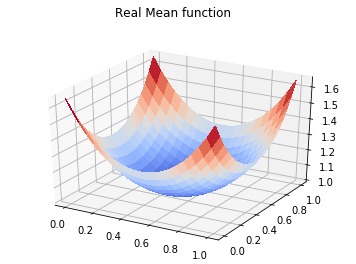

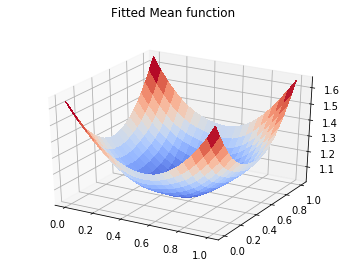

In [21]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1, t2, real_mean.reshape(num_grid),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Real Mean function')
fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1, t2, result.mean_fun,
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Fitted Mean function')
plt.show()


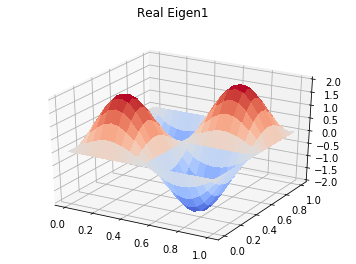

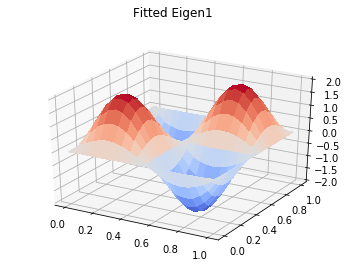

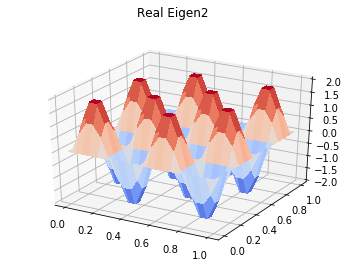

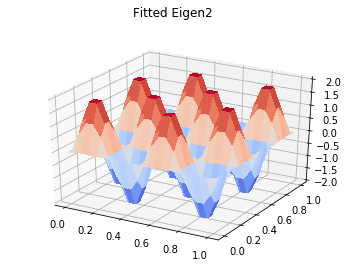

Real eigen values: 4, 1
Fitted eigen values: 3.44233393669, 0.749396562576




In [22]:

fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1, t2, real_eigfun1.reshape(num_grid),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
ax.set_zlim3d(-2, 2)
plt.suptitle('Real Eigen1')

fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
direction1 = ((np.dot(real_eigfun1, result.eig_fun[0].reshape(-1)) > 0) - 0.5) * 2
surf = ax.plot_surface(t1, t2, direction1 * result.eig_fun[0].astype('f8'),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
ax.set_zlim3d(-2, 2)
plt.suptitle('Fitted Eigen1')

fig3 = plt.figure(3)
ax = fig3.gca(projection='3d')
surf = ax.plot_surface(t1, t2, real_eigfun2.reshape(num_grid),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
ax.set_zlim3d(-2, 2)
plt.suptitle('Real Eigen2')

fig4 = plt.figure(4)
ax = fig4.gca(projection='3d')
direction2 = ((np.dot(real_eigfun2, result.eig_fun[1].reshape(-1)) > 0) - 0.5) * 2
surf = ax.plot_surface(t1, t2, direction2 * result.eig_fun[1].astype('f8'),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
ax.set_zlim3d(-2, 2)
plt.suptitle('Fitted Eigen2')
plt.show()
print("Real eigen values: %s" %", ".join(map(str, eig_val)))
print("Fitted eigen values: %s" %", ".join(map(str, result.eig_val[0:2].astype('f8'))))
print("\n")

In [23]:
print("Real Sigma2: %f" %sigma2)
print("Fitted Sigma2: %f" %result.sigma2)

Real Sigma2: 0.160000
Fitted Sigma2: 0.662337


In [24]:
print('Estimate pc scores by PACE')
mse_pc = np.mean((pc_score - result.fpc_scores[:, 0:2] * np.array([direction1, direction2]))**2, axis = 0)
print('MSE of pc_scores: %s' %", ".join(map(str, mse_pc)))

Estimate pc scores by PACE
MSE of pc_scores: 0.000456741146208, 0.000641269809118


In [25]:
fit_funx_fpc_scores, fit_funx = result.Restruct_Fun(t_of_fun.take(np.arange(4), 0), y.take(np.arange(4), 0))


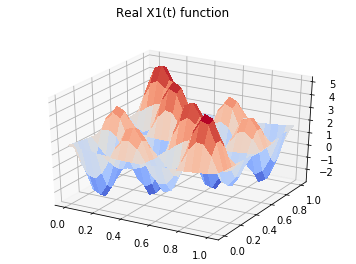

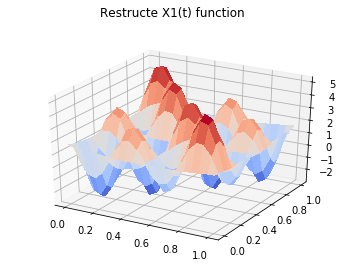

In [26]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1, t2, (real_mean + real_eigfun1 * pc_score[0, 0] + real_eigfun2 * pc_score[0, 1]).reshape(num_grid),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Real X1(t) function')
# plt.savefig('d:/Work_Jupyter/Gpu/Picture/2d_regular_real_X' + str(1))

fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1, t2, fit_funx[0].astype('f8'),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Restructe X1(t) function')
# plt.savefig('d:/Work_Jupyter/Gpu/Picture/2d_regular_X' + str(1))
plt.show()

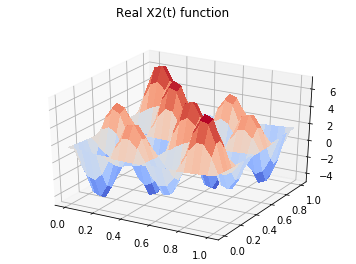

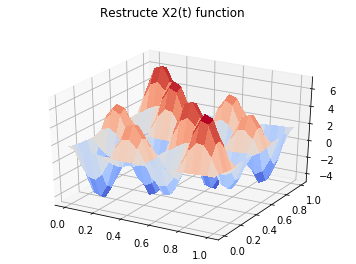

In [27]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1, t2, (real_mean + real_eigfun1 * pc_score[1, 0] + real_eigfun2 * pc_score[1, 1]).reshape(num_grid),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Real X2(t) function')
# plt.savefig('d:/Work_Jupyter/Gpu/Picture/2d_regular_real_X' + str(2))

fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1, t2, fit_funx[1].astype('f8'),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Restructe X2(t) function')
# plt.savefig('d:/Work_Jupyter/Gpu/Picture/2d_regular_X' + str(2))
plt.show()

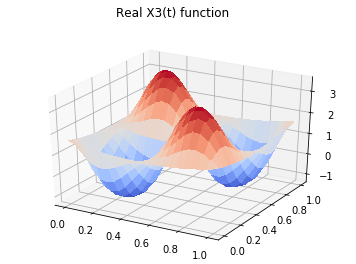

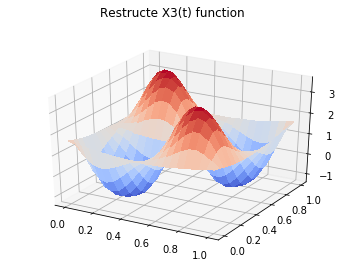

In [28]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1, t2, (real_mean + real_eigfun1 * pc_score[2, 0] + real_eigfun2 * pc_score[2, 1]).reshape(num_grid),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Real X3(t) function')
fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1, t2, fit_funx[2].astype('f8'),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Restructe X3(t) function')
plt.show()

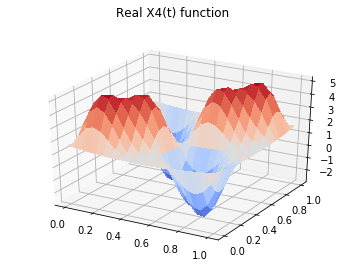

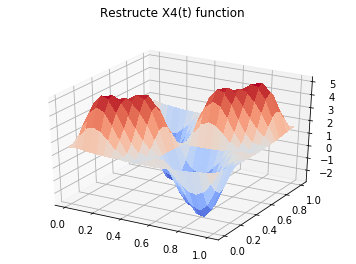

In [29]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1, t2, (real_mean + real_eigfun1 * pc_score[3, 0] + real_eigfun2 * pc_score[3, 1]).reshape(num_grid),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Real X4(t) function')
fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1, t2, fit_funx[3].astype('f8'),
                        rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0.1, antialiased=False)
plt.suptitle('Restructe X4(t) function')
plt.show()

In [30]:
ISE = np.zeros(num_fun)
fit_x = result.Restruct_Fun(t_of_fun, y)[1]
dt = 1 / (num_grid - 1).prod()
for i in range(num_fun):
    ISE[i] = ((fit_x.take(i, 0) -  (real_mean + real_eigfun1 * pc_score[i, 0] + real_eigfun2 * pc_score[i, 1]).reshape(num_grid))**2).sum() * dt

MISE = ISE.mean()
print(MISE)

0.00161227222076
